In [188]:
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_federated as tff

import matplotlib.pyplot as plt

In [206]:
NUMBER_TO_LABEL = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [180]:
SAVE_DIR = Path("/home/ole/masterarbeit/flidp/dataset-cache/cifar10")

In [2]:
train_ds = tfds.load("cifar10", split="train")
test_ds = tfds.load("cifar10", split="test")

2024-07-24 13:41:10.743856: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 13:41:10.916245: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 13:41:10.916280: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 13:41:10.918263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 13:41:11.032377: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 13:41:11.033280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
train_df = tfds.as_dataframe(train_ds)
test_df = tfds.as_dataframe(test_ds)
len(train_df), len(test_df)

(50000, 10000)

In [75]:
TRAIN_CLIENTS = 500
TEST_CLIENTS = 100

In [6]:
train_label_counts = train_df['label'].sort_values().value_counts().to_numpy()
test_label_counts = test_df['label'].sort_values().value_counts().to_numpy()

train_label_counts, test_label_counts

(array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [16]:
def init_client_distributions(num_clients, label_counts):
    return np.random.dirichlet(label_counts / sum(label_counts), size=num_clients)

In [132]:
def init_client_labels(num_clients, examples_per_label):
    """Assigns labels to clients by giving a label distribution to each client that is drawn from a dirichlet distribution."""
    assert min(examples_per_label) > 0, "There are some labels that don't have any examples!"
    examples_per_label = examples_per_label.copy()
    labels = np.array(range(len(examples_per_label))).astype(int)
    client_labels = np.zeros((num_clients, len(labels))).astype(int)
    current_client = 0
    while len(labels) > 0:
        client_distributions = init_client_distributions(num_clients, examples_per_label)
        while min(examples_per_label) > 0:
            new_label = np.random.choice(labels, p=client_distributions[current_client])
            new_label_pos = np.argwhere(labels == new_label) 
            examples_per_label[new_label_pos] -= 1
            client_labels[current_client][new_label] += 1
            current_client = (current_client + 1) % num_clients
        empty_label = labels[np.argmin(examples_per_label)]
        labels = labels[np.where(labels != empty_label)]
        examples_per_label = examples_per_label[examples_per_label > 0]

    return client_labels

In [167]:
def assign_examples_to_clients(client_labels, df):
    """Assigns each example to a random client that has a count for the example's label > 0. Returns a list of those assignments"""
    assert np.sum(client_labels) == len(df), "The total number of examples mismatch."
    client_labels = client_labels.copy()
    client_assignments = []
    for i in range(len(df)):
        ex = df.iloc[i]
        label = ex['label']
        clients_for_label = client_labels[:, label]
        possible_clients = np.argwhere(clients_for_label > 0).reshape(-1)
        selected_client = np.random.choice(possible_clients)
        client_assignments.append(selected_client)
        client_labels[selected_client, label] -= 1    
    
    assert np.all(client_labels == 0)

    return client_assignments

In [175]:
def assign_clients_to_df(df, num_clients):
    label_counts = df['label'].sort_values().value_counts().to_numpy()
    client_labels = init_client_labels(num_clients, label_counts)
    client_assignments = assign_examples_to_clients(client_labels, df)
    df['client_ids'] = pd.Series(client_assignments).map(lambda x: f"client_{x}")

    return df

In [176]:
train_df = assign_clients_to_df(train_df, TRAIN_CLIENTS)
test_df = assign_clients_to_df(test_df, TEST_CLIENTS)

In [195]:
def make_client_getter(df):
    def get_tf_dataset_for_client(client_id):
        client_df = df[df['client_ids'] == client_id]
        client_images = tf.convert_to_tensor(client_df['image'].to_list(), dtype=tf.int64)
        client_labels = tf.convert_to_tensor(client_df['label'].to_list(), dtype=tf.int64)
        
        client_ds = tf.data.Dataset.from_tensor_slices(
            {
                'image': client_images[:], 
                'label': client_labels[:],
            }
        )
        return client_ds
    return get_tf_dataset_for_client

In [196]:
tff.simulation.datasets.save_to_sql_client_data(
    client_ids=train_df['client_ids'].unique(),
    dataset_fn=make_client_getter(train_df),
    database_filepath=str(SAVE_DIR / 'train.sqlite'),
    allow_overwrite=True,
)

In [197]:
tff.simulation.datasets.save_to_sql_client_data(
    client_ids=test_df['client_ids'].unique(),
    dataset_fn=make_client_getter(test_df),
    database_filepath=str(SAVE_DIR / 'test.sqlite'),
    allow_overwrite=True,
)

In [202]:
def load_cifar10(dir: str):
    tensor_spec = {
        'image': tf.TensorSpec((32, 32, 3), dtype=tf.int64),
        'label': tf.TensorSpec((), dtype=tf.int64),
    }
    train_client_data =  tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(dir) / 'train.sqlite'), element_spec=tensor_spec, split_name=None)
    test_client_data = tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(dir) / 'test.sqlite'), element_spec=tensor_spec, split_name=None)
    return train_client_data, test_client_data

In [203]:
fed_train_ds, fed_test_ds = load_cifar10(SAVE_DIR)

(<matplotlib.image.AxesImage at 0x768d2ce06a50>, 'ship')

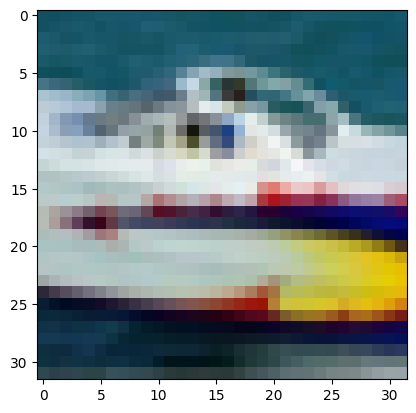

In [209]:
client_id = "client_23"
client_ds = fed_train_ds.create_tf_dataset_for_client(client_id)
client_example = next(client_ds.as_numpy_iterator())
plt.imshow(client_example['image']), NUMBER_TO_LABEL[client_example['label']]

In [210]:
def plot_label_dist_for_clients(label_df, client_ids):
    label_counts = (
        label_df
        .groupby(['client_ids', 'label'])
        .value_counts()
        .reset_index()
        .pivot(index='client_ids', columns='label', values='count')
        .fillna(0)
    )

    def prepare_axis(ax, ax_num):
        if not (ax_num == 0):
            ax.tick_params(left=False)
            ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.tick_params(labelbottom=False)

    fig = plt.figure(figsize=(15,5))
    axes = fig.subplots(ncols=len(client_ids), sharey=True, sharex=True, squeeze=True)
    for i, ax in enumerate(axes):
        prepare_axis(ax, i)
    for ax, (cid, labels) in zip(axes, label_counts.loc[client_ids].iterrows()):
        labels.plot(kind='bar', sharey=True, sharex=True, fig=fig, ax=ax, title=f"Client {cid}", xlabel='')

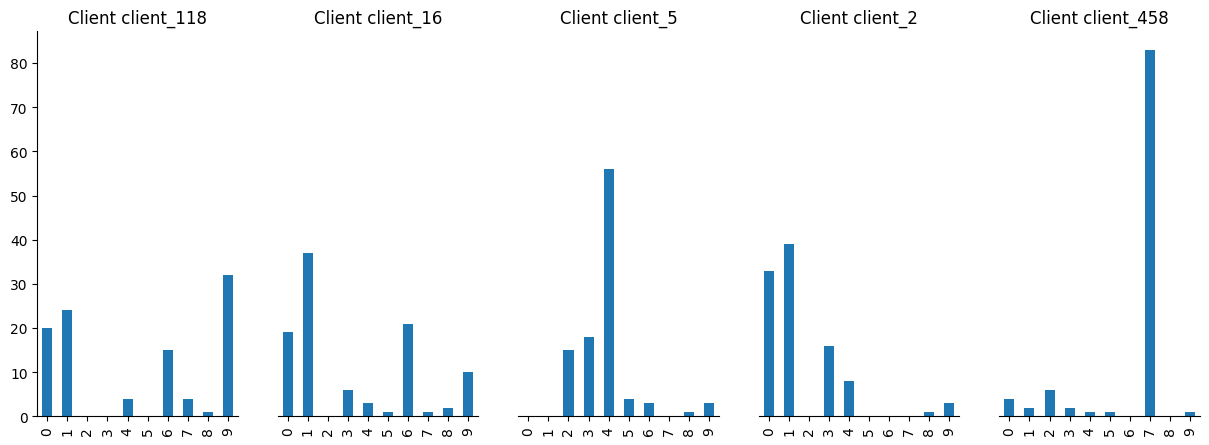

In [217]:
viz_clients = np.random.choice(train_df['client_ids'].unique(), size=5, replace=False).tolist()
plot_label_dist_for_clients(train_df[['client_ids', 'label']], viz_clients)